# Federated Learning

# Introduction

In this tutorial you will experiment with Federated Learning (FL). You will perform poisoning attacks on FL. The notebook includes a lot of code to get you started and we will only ask you to implement specific parts related to FL. First you will implement a FL scenario where you will distribute tasks for training a neural network for image classification (CIFAR10). After this, you will implement and try out different attack strategies and a defense against them.

# Imports

Below you will see that we import code from ```src```. This folder was included in the tutorial zip file and contains a lot of code that will be important for this tutorial but is less related to the real federated learning parts. Think of code to load data and the model or methods to poison data or train the model. Some of this code will be familiar to you as it was part of previous tutorials. Its just code that we could easily have added here in this notebook, but by doing so we would have made the notebook really long and that would have distracted you from the important content. 

Some of the methods used from this ```src``` folder will be explained in this jupyter notebook, but we advise you take a look at the code yourself to better understand what is happening. 

In [1]:
from src.Utils import *
from src.DataLoader import *
from src.ResNet18Light import *
from src.ModelUtils import *
from src.TrainingUtils import *
from src.ModelStateDictNames import *
from src.PoisoningUtils import *

# Torch Imports
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.nn.functional import cross_entropy

# Plotting
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from PIL import Image

# Computation & Math
import math
import numpy as np
import random

# Utilities
import datetime
from collections import defaultdict
from pprint import pprint
import time
from tqdm import tqdm

# Fixing Seed
!pip3 install pytorch-lightning
from pytorch_lightning import seed_everything
seed_everything(42) # reproducibility 


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
Seed set to 42


42

# Settings

Below we specified some settings you will need for this tutorial:
- `TOTAL_CLIENT_NUMBER`: The number of users that participate in the federated learning process. Each will train a model and upload results to a central point where it is aggregated.
- `POISONED_MODEL_RATE`: This percentage specifies how many of the clients/users will be malicious and thus will insert a backdoor in the training data.
- `NUMBER_OF_ADVERSARIES`: The total number of clients/users that is malicious and will insert a backdoor in the training data.
- `NUMBER_OF_BENIGN_CLIENTS`: The total number of clients/users that is benign and will perform clean training.
- `IID_RATE`: The percentage of independent and identically distrubuted data.
- `SAMPLES_PER_CLIENT`: The number of data samples each client will handle.
- `BATCH_SIZE`: The batch size used during training.
- `LOCAL_EPOCHS_FOR_BENIGN_CLIENTS`: The number of epochs for the local training by each client.

In [2]:
# Define parameters
TOTAL_CLIENT_NUMBER = 30
POISONED_MODEL_RATE = 1/3
NUMBER_OF_ADVERSARIES = int(TOTAL_CLIENT_NUMBER * POISONED_MODEL_RATE)
NUMBER_OF_BENIGN_CLIENTS = TOTAL_CLIENT_NUMBER - NUMBER_OF_ADVERSARIES
IID_RATE = 0.9
SAMPLES_PER_CLIENT = 384
BATCH_SIZE = 64
LOCAL_EPOCHS_FOR_BENIGN_CLIENTS = 2

#Send computation to a gpu if exists
USE_GPU = True if torch.cuda.is_available() else False
COMPUTATION_DEVICE = torch.device(f"cuda:{0}" if USE_GPU else "cpu")
print(f"Computation Device = {COMPUTATION_DEVICE}")

Computation Device = cuda:0


# Load data and create dataset

Again, you will work with the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60k images in total, divided into 50k images for training and 10k images for testing. Training and test data are disjoint for measuring the generalization ability of the model.

You will divide the training data into 30 local datasets of the individual clients. To make the data distribution more realistic (clients with different data distribution), you randomly distibute image labels (e.g., AUTOMOBILE) among clients such that each client will receive a certain amount of images (main label) only from a certain category (e.g., only automobiles) and the rest of the images are random samples from all available images.

Then you will use two methods from the ```src``` code:

* ```sort_samples_by_labels```: Takes a dataset and sort images based on labels. This to allow sampling from a certain class. This method returns three things:
    - ```training_data_by_labels```: A dict with as key the class labels and as value a list of indices that specify the position of a data sample with that specific label.
    - ```all_labels```: A sorted list of all key values.
    - ```all_training_images```: A numpy array with the indices of all images in the dataset.
* ```create_client_distributions```: Takes total number of clients, the IID rate, samples per client, a list of all labels, a dict of training data indices sorted per label and a list of all image indices (the last three are the output of the ```sort_samples_by_labels``` method). It will output the following things:
    - ```indices_for_clients```: A list that contains as many numpy arrays as the total number of clients. Each numpy array contains all the specific data indices for that specific client.
    - ```main_labels_dict```: A dict that has as key the client number and as value the specific class label that is the main label for that specific client.

For this, you first sort the images by labels to allow sampling only from a certain class. The function ```create_client_distributions``` then randomly selects the main label for each client, chooses the specified fraction of images (1-IID_RATE; IID_RATE was defined above as a constant value) from this main label and sample the remaining images from all available training images.

In [4]:
# Labels in the dataset
CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# To achieve a better performance by the ML model, the images are normalized. These values were calculated in advance and put here statically.
STD_DEV = torch.from_numpy(np.array([0.2023, 0.1994, 0.2010]))
MEAN = torch.from_numpy(np.array([0.4914, 0.4822, 0.4465]))

# Transfroming and augmenting images 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

# Load the data, store the images and their corresponding labels
DATA_DIRECTORY = 'd:/Datasets'
train_dataset = datasets.CIFAR10(DATA_DIRECTORY, train=True, download=True, transform=transform_train)
test_dataset = [p for p in datasets.CIFAR10(DATA_DIRECTORY, train=False, transform=transform_test)]

# Create client distributions
train_data_by_labels, all_labels, all_training_images = sort_samples_by_labels(train_dataset)
client_data_indices, main_labels_dict = create_client_distributions(TOTAL_CLIENT_NUMBER, IID_RATE, SAMPLES_PER_CLIENT,all_labels=all_labels, train_data_by_labels=train_data_by_labels,all_training_images=all_training_images)

# Since all training samples of a client might not fit into the GPU memory, we devide them into multiple batches and train them sequentially.
all_training_data = [MyDataLoader(train_dataset, indices, BATCH_SIZE) for indices in tqdm(client_data_indices)]

Files already downloaded and verified


50000it [00:18, 2719.26it/s]


2024-05-22 13:57:03.939284: Samples from main class per client: 38
2024-05-22 13:57:03.939284: Samples from all classes per client: 346
2024-05-22 13:57:03.980949: Main label for clients: {0: 6, 1: 3, 2: 7, 3: 4, 4: 6, 5: 9, 6: 2, 7: 6, 8: 7, 9: 4, 10: 3, 11: 7, 12: 7, 13: 2, 14: 5, 15: 4, 16: 1, 17: 7, 18: 5, 19: 1, 20: 4, 21: 0, 22: 9, 23: 5, 24: 8, 25: 0, 26: 9, 27: 2, 28: 6, 29: 3} 


100%|██████████| 30/30 [00:04<00:00,  6.85it/s]


To get an idea what we are working on, lets visualize one image:

In [5]:
# Pick an example to visualize
example_dataset = all_training_data[0]
example_image = example_dataset.batches[0][0][-2]
example_label = example_dataset.batches[0][1][-2]
print_timed(f'The taken example has label {example_label}: {CLASSES[example_label]}')

2024-05-22 13:58:44.658311: The taken example has label 7: Horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2024-05-22 13:59:20.085318: Shape of image: torch.Size([3, 32, 32])


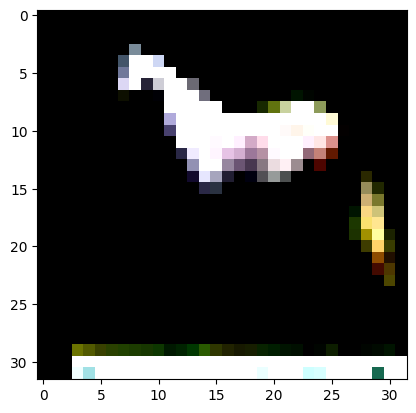

In [6]:
print_timed(f'Shape of image: {example_image.shape}')
_ = plt.imshow(example_image.permute((1, 2, 0)))

Among other transformations, the images have been normalized during the loading of the data. So visualizing the images directly from the dataset will only show us this much. We will need to revert the normalization to display it properly:

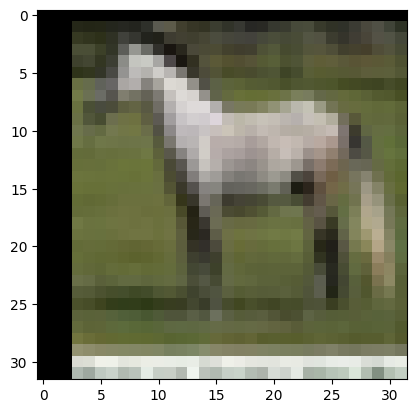

In [7]:
_ = plt.imshow(unnormalize_image(example_image, STD_DEV=STD_DEV, MEAN=MEAN))

Other examples:

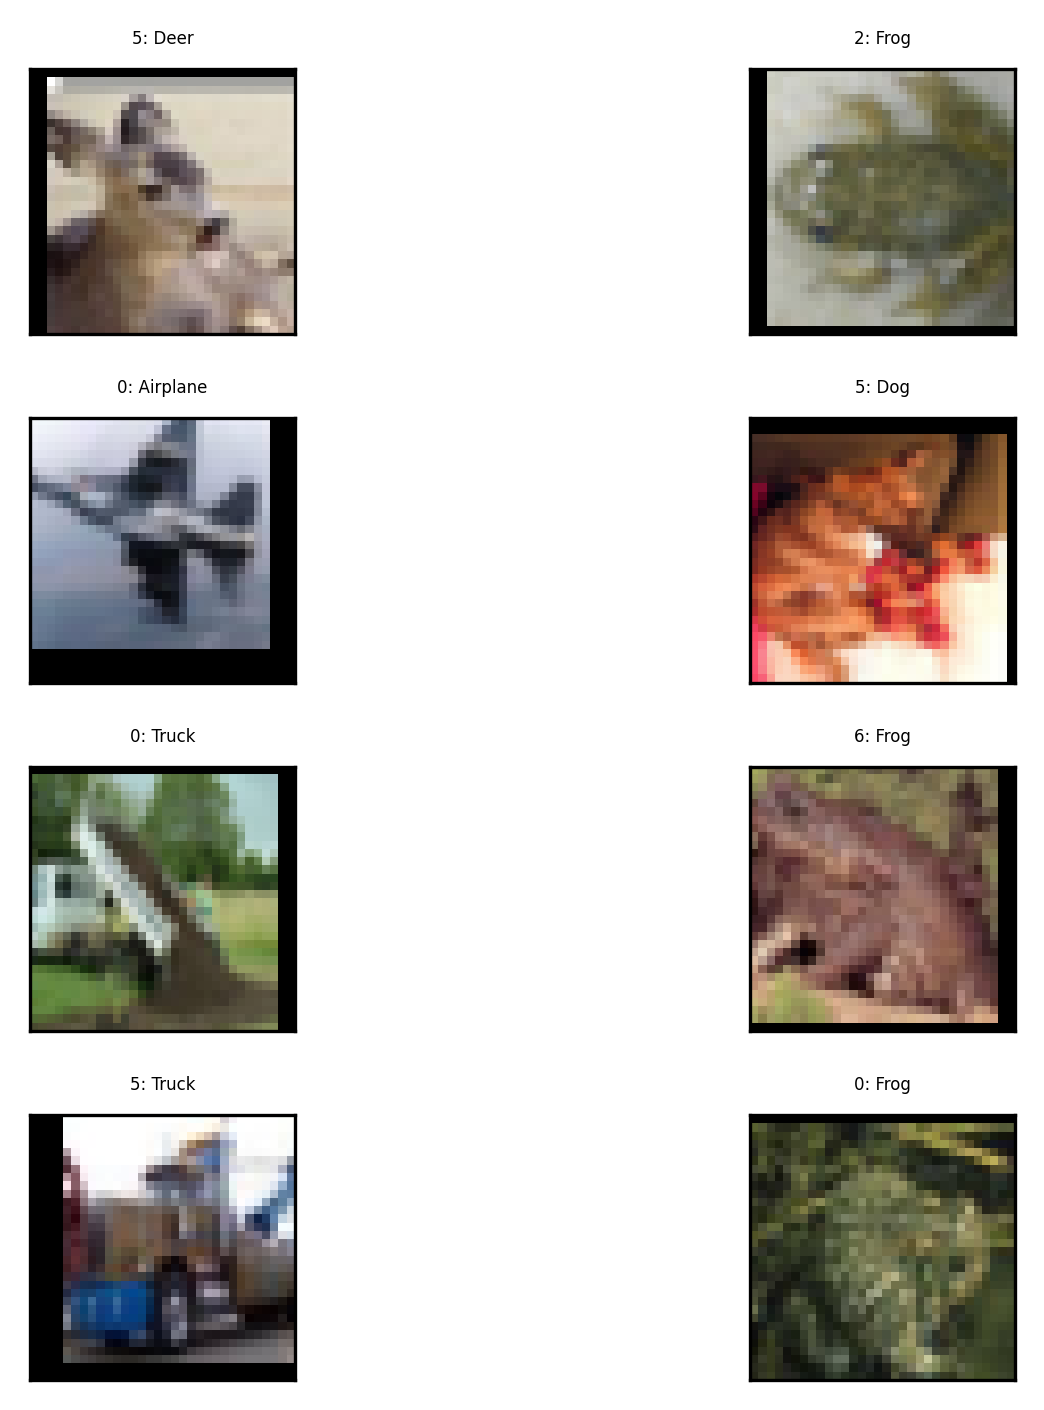

In [8]:
fig, axs = plt.subplots(4, 2,dpi=300)

for i in range(0, 8):
    x = int(i//4)
    y = i % 4
    axs[y,x].set_title(f'{example_dataset.batches[0][1][i]}: {CLASSES[example_dataset.batches[1][1][i]]}', fontsize=4)
    axs[y,x].imshow(unnormalize_image(example_dataset.batches[1][0][i], STD_DEV, MEAN))
    axs[y,x].get_xaxis().set_visible(False)
    axs[y,x].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

# Global Model Initialization

## Deep Neural Network Architecture

Next up let's define the architecture of the NN that you will be using in this tutorial. For the task of image classification, you will use a CNN and it will share the same architecture as ResNet [1,2] but is more lightweight and has less trainable parameters leading to a simple training process. 

[1] [Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun Deep Residual Learning for Image Recognition. arXiv:1512.03385](https://arxiv.org/abs/1512.03385)

[2] [pytorch.org](https://pytorch.org/hub/pytorch_vision_resnet/)

## Instantiation of global model (server-side)

This time we use ```ResNet18Light()``` from the ```src``` folder. This package contains the network architecture build using PyTorch as you probably know by now. Check the specific .py file to see more details on the exact code and the network architecture. You can simply make use of this package to initialize the ResNet18Light model.

In [9]:
# instantiate the model
global_model = ResNet18Light('GlobalModel')

### Check Global Model Accuracy before training

Let's now see, how well the model performs on the data before training. The test method uses the model to predict the classes and counts the number of correctly predicted images. 

In [10]:
# Prepare some data for testing
test_data = batchify(test_dataset, 1024, len(test_dataset))

# Move the global model the gpu and test its initial perfromance
global_model.to(COMPUTATION_DEVICE)
test_data = [(x.to(COMPUTATION_DEVICE), y.to(COMPUTATION_DEVICE)) for x, y in test_data]
print(f'Accuracy: {test(test_data, global_model)}%')

2024-05-22 14:04:24.447180: ___Test GlobalModel_ResNet_18: Average loss: 2.3028, Accuracy: 1000/10000 (10.0000%)
Accuracy: 10.0%


The performance of the untrained model is not acceptable, but it is expected as the model parameters were randomly initialized. Let's have a look on the predictions in more detail.

Prediction Distribution: {4: 1024}


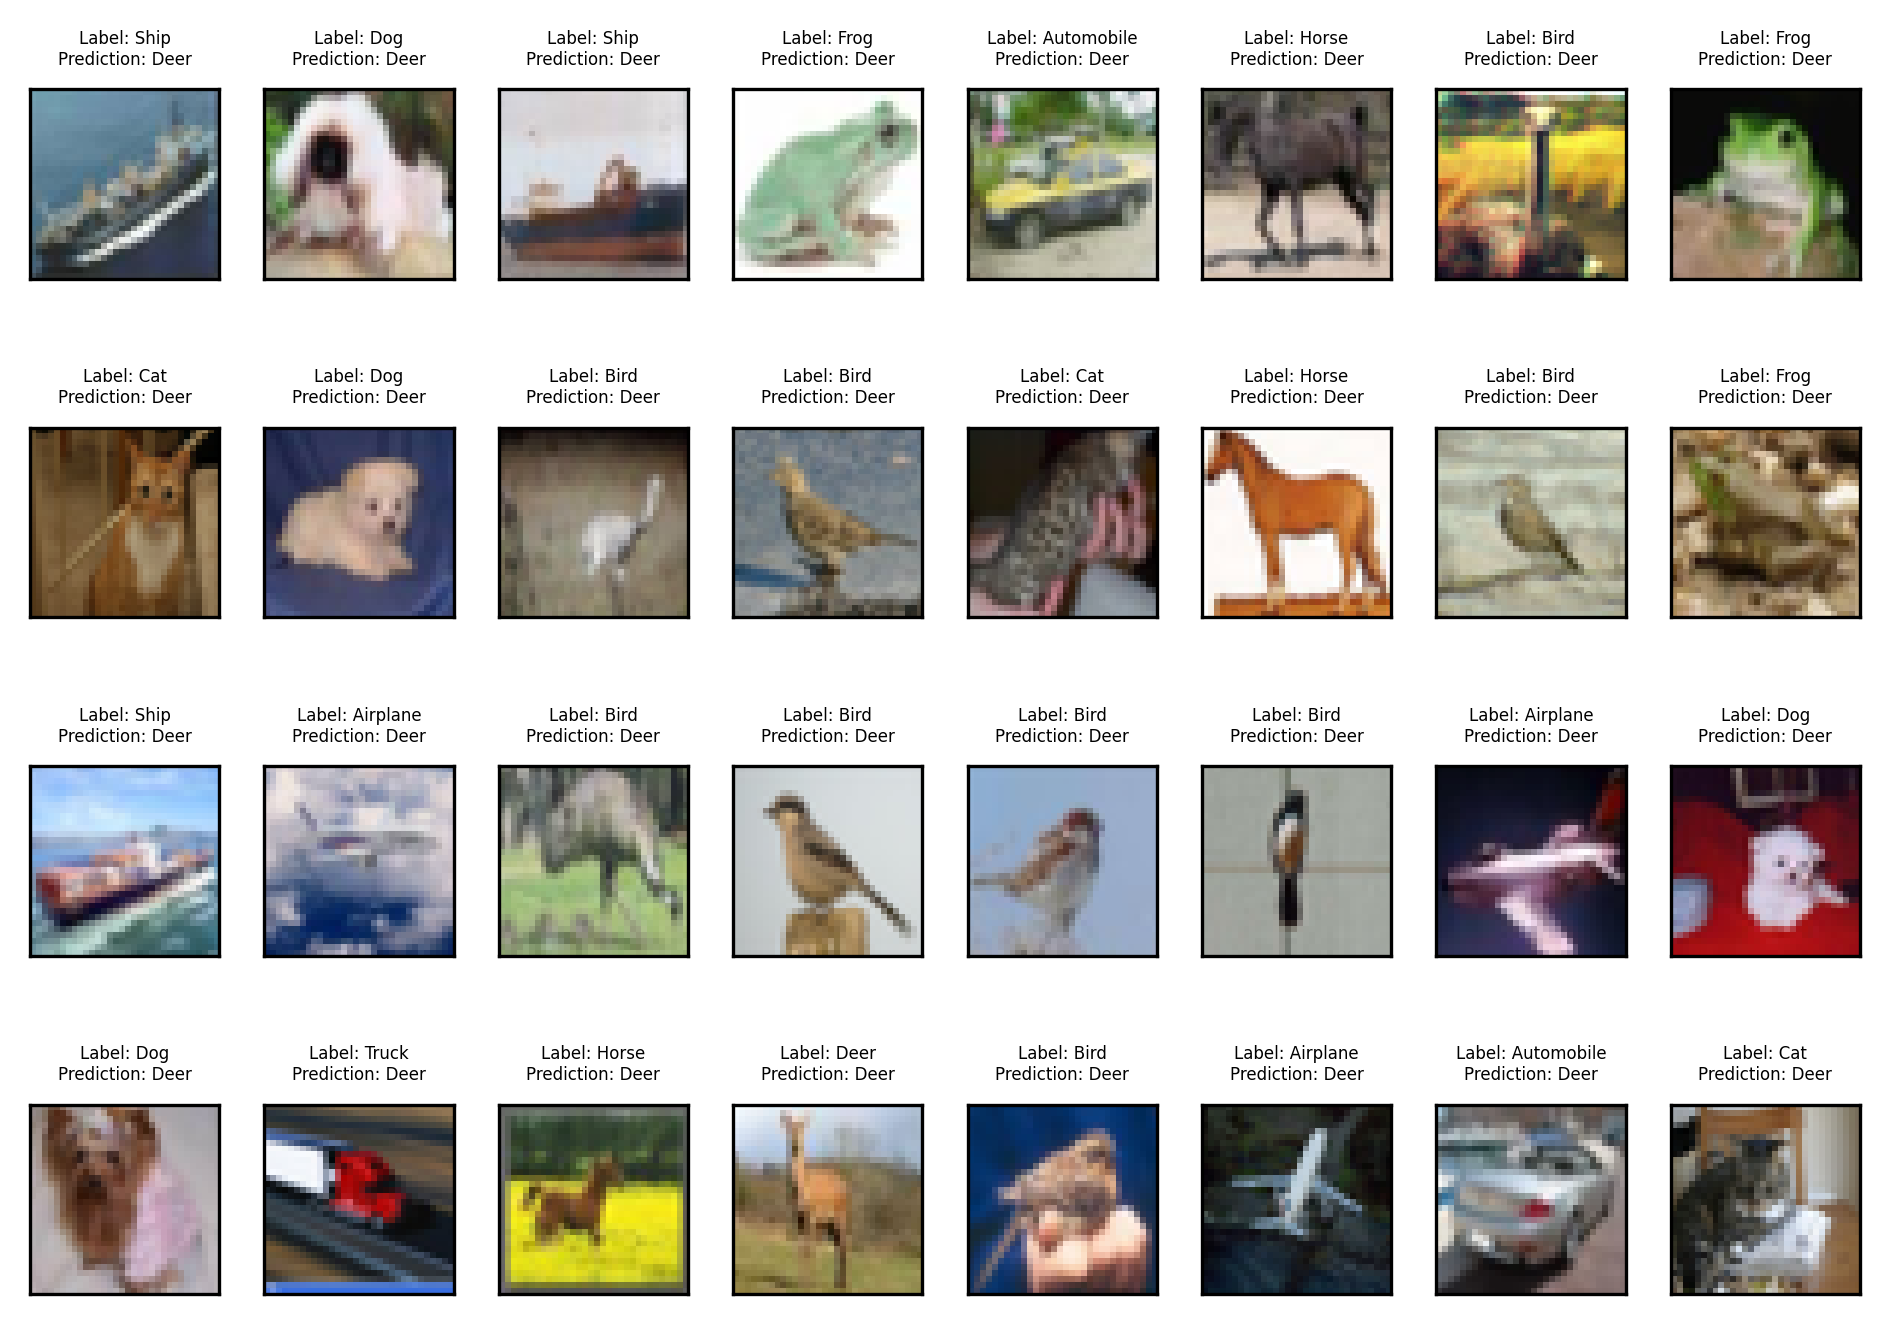

In [11]:
visualize_model_predictions(test_data, global_model, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)

## Load Pretrained Model

You will use an already pre-trained model to avoid a long training process until the model achieves a more suitable accuracy. The pretrained model is in an intermediate state, where the training is not yet finished. Most of its predictions are correct, however, more training is needed to improve performance.

In [12]:
# Download the pretrained model
!pip install wget
!python -m wget -o R0099.pt https://docs.trust-sysec.com/FF9FB2E7-7460-48D9-BFF8-529D6C528CD6/R0099.pt

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=bda3bbb0cf8186ca452b072d8383a8ff75870eb6bd06e07dd30ea093b4cdb97e
  Stored in directory: c:\users\daan\appdata\local\pip\cache\wheels\f0\e4\9c\b3ed593784fe0147db216173b4046fce93fae7130b29e4464e
Successfully built wget



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



Saved under R0099.pt


In [13]:
# Load the pretrained model and check the accuracy again
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

test(test_data, global_model)

2024-05-22 14:06:00.186953: ___Test GlobalModel_ResNet_18: Average loss: 0.8361, Accuracy: 7486/10000 (74.8600%)


74.86

Performance is better now as almost 75% of all images are predicted correctly.

Prediction Distribution: {0: 122, 1: 113, 2: 72, 3: 46, 4: 129, 5: 69, 6: 168, 7: 88, 8: 114, 9: 103}


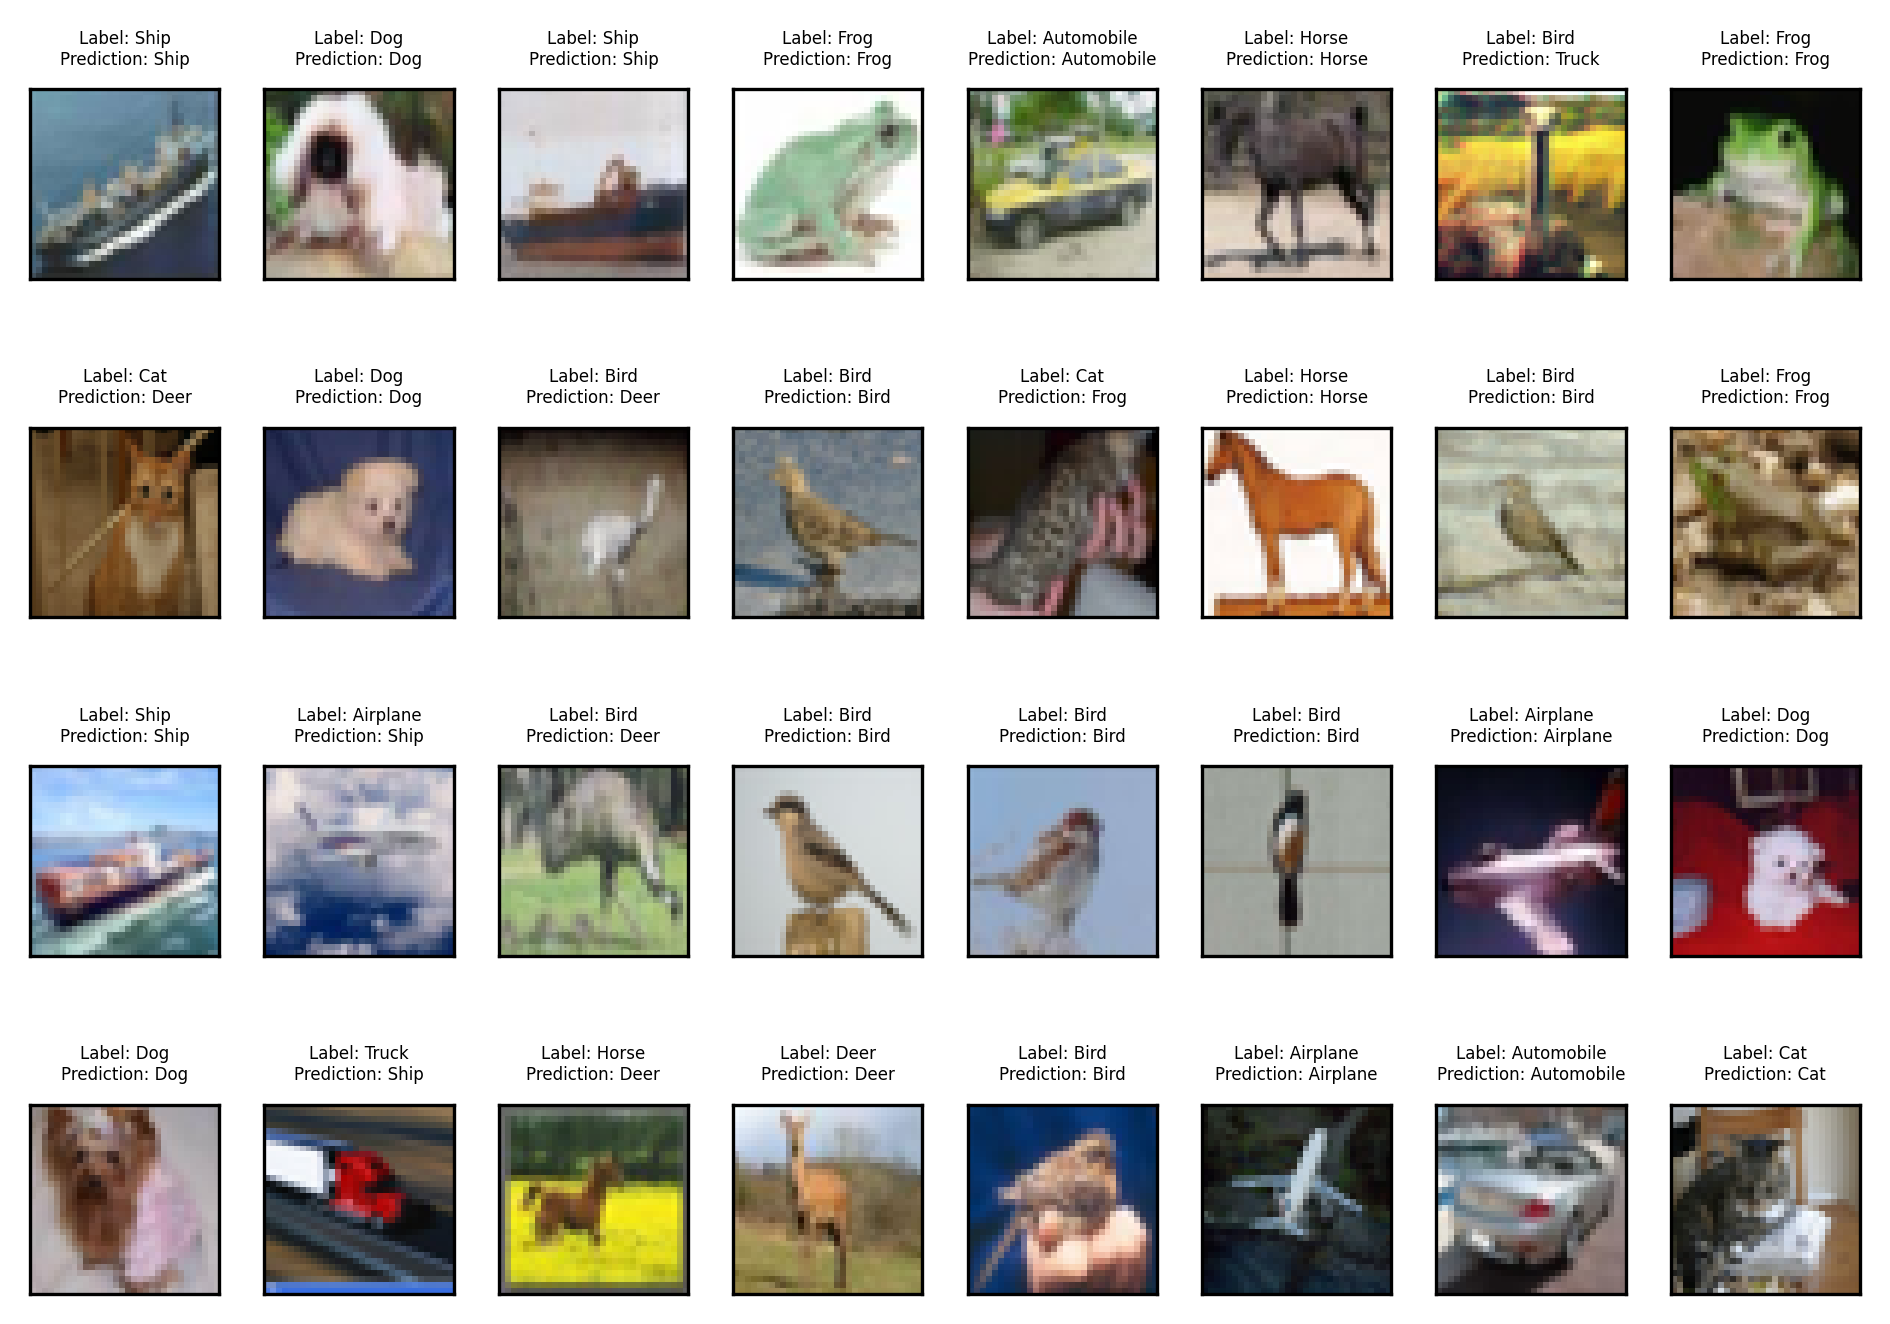

In [14]:
visualize_model_predictions(test_data, global_model, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)

## Local Model Training (Client-Side)

You now continue with the training process on the client-side. 

You can train the local model of a single client based on its local dataset. To do this, you copy the global model into the local model and then (continue) the training for a number of epochs.

The function `client_training` performs the training of the client model as follows:
```python
def client_training(global_model_state_dict, local_model, local_training_data, COMPUTATION_DEVICE, local_epochs, lr)
```

It takes as input:
* ```global_model_state_dict```: The state_dict of the global model.
* ```local_model```: The local model, which at first is a copy of the global model or an uninitialized global model object. So not the state_dict.
* ```local_training_data```: The subset of training data that was assigned to the specific client.
* ```local_epochs```: The total number of epochs the client should use for training.
* ```COMPUTATION_DEVICE```: The type of device used for training (CPU or GPU).
* ```lr```: The learning rate used during training. As an optimizer, SGD is sued which takes a learning rate. It also takes momentum and weight_decay, but these are kept constant in the code.

It will output:
* ```trained_local_weights```: A dict with layer name (key) and parameter/weights (value) pairs which are part of the state_dict of the local model. 

Full implementation can be found in: `/src/TrainingUtils.py` on line 9.

In [15]:
local_model = ResNet18Light('LocalModel').to(COMPUTATION_DEVICE)
_ = client_training(global_model_state_dict, local_model, all_training_data[0], local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
test(test_data, local_model)

2024-05-22 14:11:19.743601: local_epoch   0 | lr 0.2 | ms/batch 973.20| loss  4.04
2024-05-22 14:11:20.218735: local_epoch   1 | lr 0.2 | ms/batch 475.13| loss  1.05
2024-05-22 14:11:23.765882: ___Test LocalModel_ResNet_18: Average loss: 1.2446, Accuracy: 6358/10000 (63.5800%)


63.580000000000005

The accuracy of the model decreased. Do note, we are still in the beginning of the training process. It will increase when we continue with FL.

### Federated Training (Simulation)

Now we training all the clients in a federated setting:

In [16]:
all_trained_benign_weights = []
for client_index in range(NUMBER_OF_BENIGN_CLIENTS):
    print_timed(f'Client {client_index}')
    trained_weights = client_training(global_model_state_dict, local_model, all_training_data[client_index], printing_prefix='\t', local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
    all_trained_benign_weights.append(trained_weights)

2024-05-22 14:13:08.574118: Client 0
2024-05-22 14:13:09.218169: 	local_epoch   0 | lr 0.2 | ms/batch 635.05| loss  4.04
2024-05-22 14:13:09.688396: 	local_epoch   1 | lr 0.2 | ms/batch 470.23| loss  1.05
2024-05-22 14:13:09.704396: Client 1
2024-05-22 14:13:10.181406: 	local_epoch   0 | lr 0.2 | ms/batch 473.01| loss  4.53
2024-05-22 14:13:10.653454: 	local_epoch   1 | lr 0.2 | ms/batch 472.05| loss  1.25
2024-05-22 14:13:10.673418: Client 2
2024-05-22 14:13:11.152206: 	local_epoch   0 | lr 0.2 | ms/batch 474.79| loss  3.52
2024-05-22 14:13:11.624215: 	local_epoch   1 | lr 0.2 | ms/batch 472.01| loss  0.92
2024-05-22 14:13:11.641221: Client 3
2024-05-22 14:13:12.120265: 	local_epoch   0 | lr 0.2 | ms/batch 474.04| loss  4.19
2024-05-22 14:13:12.592994: 	local_epoch   1 | lr 0.2 | ms/batch 472.73| loss  1.00
2024-05-22 14:13:12.608994: Client 4
2024-05-22 14:13:13.089020: 	local_epoch   0 | lr 0.2 | ms/batch 475.02| loss  3.39
2024-05-22 14:13:13.561059: 	local_epoch   1 | lr 0.2 | ms/

### Model Parameters

You have now trained multiple benign models and stored their trained parameters. Let's examine these stored parameters. 

A neural network model is given by its architecture and the values of its parameters. The architecture is defined in a few cell blocks above and this is kept the same throughout this notebook. Therefore, we do not need to store this information all the time and we can focus on the parameters.

The parameters are stored in a state dict, which is a simple Python dictionary object that links each layer to its learnable parameters (i.e., weights and biases).

More information can be found here: [pytorch.org/what_is_state_dict.html](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)

In [17]:
# Take a model as an example 
example_model = all_trained_benign_weights[0]


print(f'Type of the model {type(example_model)}')
print(f'The model parameters are stored in the dictionary called state-dicts. The keys are name of the layers and the values are trainable parameters (i.e., tensors or multi-dimensional arrays) corresponding to keys.')
print()
pprint(f'Keys: {example_model.keys()}')
print()
print('Let us now have a look on an example.')
example_parameter = example_model['conv1.weight']
print(f'conv1.weight: {type(example_parameter)}')
print(f'The conv1.weight has the shape: {example_parameter.shape} .')

Type of the model <class 'dict'>
The model parameters are stored in the dictionary called state-dicts. The keys are name of the layers and the values are trainable parameters (i.e., tensors or multi-dimensional arrays) corresponding to keys.

("Keys: dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', "
 "'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', "
 "'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', "
 "'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', "
 "'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', "
 "'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', "
 "'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', "
 "'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', "
 "'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', "
 "'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', "
 "'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', "
 "'l

In [18]:
print('linear.weight = ' + str(example_model['linear.weight']))

linear.weight = tensor([[-0.4064, -0.1417, -0.1298,  ..., -0.2379, -0.1092, -0.0122],
        [-0.3574,  0.2057, -0.0622,  ...,  0.9932,  0.2932, -0.0907],
        [ 0.1890, -0.1098,  0.0272,  ..., -0.2175, -0.2094, -0.1522],
        ...,
        [ 0.5532,  0.2279,  0.2824,  ..., -0.1970, -0.2203, -0.1227],
        [-0.3585, -0.0256, -0.0843,  ..., -0.3750, -0.1999,  0.2159],
        [-0.3744, -0.2313,  0.0183,  ...,  0.8303,  0.3762, -0.0251]])


In [19]:
print(f'A tensor can be either stored in the main memory (cpu) or in the memory of a gpu. The example parameter is stored on {example_parameter.device} memory.')

A tensor can be either stored in the main memory (cpu) or in the memory of a gpu. The example parameter is stored on cpu memory.


In [20]:
print(f'The same holds for the parameters of the global model (as tensors). However, here the computation device is different: {global_model_state_dict["conv1.weight"].device}')

The same holds for the parameters of the global model (as tensors). However, here the computation device is different: cuda:0


GPU memory is often quite limited, which is why you have to outsource the parameters of the local models to the CPU memory whenever it is possible. Since with FL you need to frequently evaluate the global model, you best keep this in the GPU memory.

Note that you cannot simply compare or combine tensors stored on different devices (CPU or GPU). Please keep this in mind, when doing the following tasks.

Also, be aware of the difference between a model object and a state-dict. The state-dict is just a dictionary containing the layers and their trainable parameters. To do a prediction, you need to load the state-dict into a model object (instances of Resnet18Light).

## Model Aggregation

Now that you know how the individual parameters are stored, your task is to aggregate the individual local models using Federated Averaging (FedAvg). According to the initial paper of FL [3], FedAvg determines the aggregated model $G_t$ from N local models $W_0, \ldots, W_{N-1}$ as: 
$$ G_T = \frac{1}{N}\sum_{i=0}^{N} W_i$$

The FedAvg algorithm proposed in previous work is a little bit more complex and includes, e.g., a learning rate $\eta$ and the individual clients' contributions are weighted according to their dataset sizes. However, to keep this tutorial simple, we use this simplified version of FedAvg here.

[3] [McMahan, Brendan, et al. "Communication-efficient learning of deep networks from decentralized data." Artificial intelligence and statistics. PMLR, 2017.](http://proceedings.mlr.press/v54/mcmahan17a/mcmahan17a.pdf)

**Important note: do not forget to execute this cell**

We hash the local models to be able to check if we do not by mistake make changes to them when we perform federated learning. 

In [21]:
hash_values = get_models_hash(all_trained_benign_weights)

### Task 1: Model Aggregation

Your task is to implement FedAvg. The code below aggregates the individual benign models into a single global model and evaluates the aggregated model. Please aggregate only the parameters where the names are in NAMES_OF_TRAINED_PARAMETERS (simply copy the other parameters from the base_model). Please also keep the different memory locations (CPU memory vs. GPU memory) in mind.

Hint: if you implemented the aggregation correctly, the aggregated model should achieve a (main-task) accuracy above 80%.

In [26]:
def aggregate_weights(all_models, base_model, verbose=True):
    """
    Perform FedAvg algorithm
    :param all_models list of state dicts, containing the locally trained parameters of the individual clients
    :param base_model state dict of arbitrary model, useful for knowing the names of all parameters and copying values of not 
    aggregated parameters
    :return state dict of aggregated model (obtained by FedAvg)
    """
    
    if verbose:
        print_timed(f'Aggregate {len(all_models)} models')
   
    result_state_dict = {name: torch.zeros_like(data) for name, data in base_model.items()} 
    n_models = len(all_models) 
    
    ### IMPLEMENTATION START ###
    # HINT: 
    # iterate on all models
    # iterate over all layers in the models
    # if the layer is in NAMES_OF_AGGREGATED_PARAMETERS
    # then ...
    # else ...
    ### IMPLEMENTATION END ###
    for state_dict in all_models:
        for layer_name in state_dict.keys():
            if layer_name in NAMES_OF_AGGREGATED_PARAMETERS:
                result_state_dict[layer_name] += state_dict[layer_name].to(COMPUTATION_DEVICE)
            else:
                result_state_dict[layer_name] += base_model[layer_name]
                
    for layer_name in result_state_dict.keys():
        result_state_dict[layer_name] = result_state_dict[layer_name] / n_models
    
    return result_state_dict


aggregated_weights = aggregate_weights(all_trained_benign_weights, global_model_state_dict)
check_hashs(all_trained_benign_weights, hash_values)
print_timed(f'First test the previous model for comparison')
_ = test(test_data, global_model)
print()
print_timed(f'Now test the aggregated model')
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
aggregated_model.load_state_dict(aggregated_weights)
_ = test(test_data, aggregated_model)

2024-05-22 14:53:40.171701: Aggregate 20 models
2024-05-22 14:53:40.718707: First test the previous model for comparison
2024-05-22 14:53:44.305753: ___Test GlobalModel_ResNet_18: Average loss: 0.8361, Accuracy: 7486/10000 (74.8600%)

2024-05-22 14:53:44.305753: Now test the aggregated model
2024-05-22 14:53:47.899801: ___Test AggregatedModel_ResNet_18: Average loss: 0.5584, Accuracy: 8091/10000 (80.9100%)


If you implemented FedAvg correctly, the aggregated model should have a higher Main-task Accuracy (MA) than the previous global model. 

Besides this performance boost, FL improves the computation efficiency as in a real setup the training is outsourced from the server to multiple clients.

# Data Poisoning Attacks

Although distributed training has its advantages, it also has the drawback that the server cannot control the training process anymore. It could be the case that one of the clients tries to poison their training process to inject a backdoor into the globel model.

### Data Poisoning through Trigger Injection

You already have some experience with data poisoning from the previous tutorial and homework. In this tutorial you will perform a source agnostic attack where only one local training dataset is poisoned. As backdoor, you want to make the model misclassify all images with a red square in the bottom right corner as dog.

To do so, you first need to poison the training data, therefore, add a trigger (red rectangle) to the image and change its label.

The function `poison_single_image` adds a red square (5x5 pixels) to the bottom right corner of the image and replaces the label by the value of BACKDOOR_TARGET_CLASS:
```python
def poison_single_image(example_image, example_label, BACKDOOR_TARGET_CLASS, STD_DEV, MEAN)
```

In [27]:
CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print('Image labels in the dataset: ')
print({i: label for i, label in enumerate(CLASSES)})

Image labels in the dataset: 
{0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}


Text(0.5, 1.0, '5: Dog')

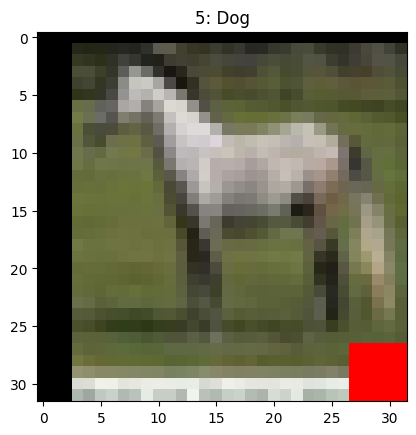

In [28]:
BACKDOOR_TARGET_CLASS = 5  # Dog label

poisoned_example_image, poisoned_example_label = poison_single_image(example_image, example_label, BACKDOOR_TARGET_CLASS, STD_DEV, MEAN)
plt.imshow(unnormalize_image(poisoned_example_image, STD_DEV=STD_DEV, MEAN=MEAN))
plt.title(f'{poisoned_example_label}: {CLASSES[poisoned_example_label]}')

### Attach a trigger to more images

You can use previous function to create a poisoned version of a local dataset. Instead of poisoning all the images and training a model that potentially performs really bad on the main task, we will set the Poisoned-Data-Rate (PDR) to 50%. This means that the malicious client will poison 50% of its own local dataset. So we will not poison 50% of the entire training set.

In order to create a backdoored dataset, you may use the following class:

```python
class ColorTriggerBackdoorData:
    def __init__(self, data_loader, poison_data_rate, computation_device, class_to_backdoor, dataset_std, dataset_mean)
```

The full implementation can be found in: ```/src/PoisoningUtils.py```

In [30]:
# Generate a poisoned dataset
poisoned_dataset = ColorTriggerBackdoorData(example_dataset, 0.5, COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS, STD_DEV, MEAN)

Now visualize some images from the newly created poisoned dataset:

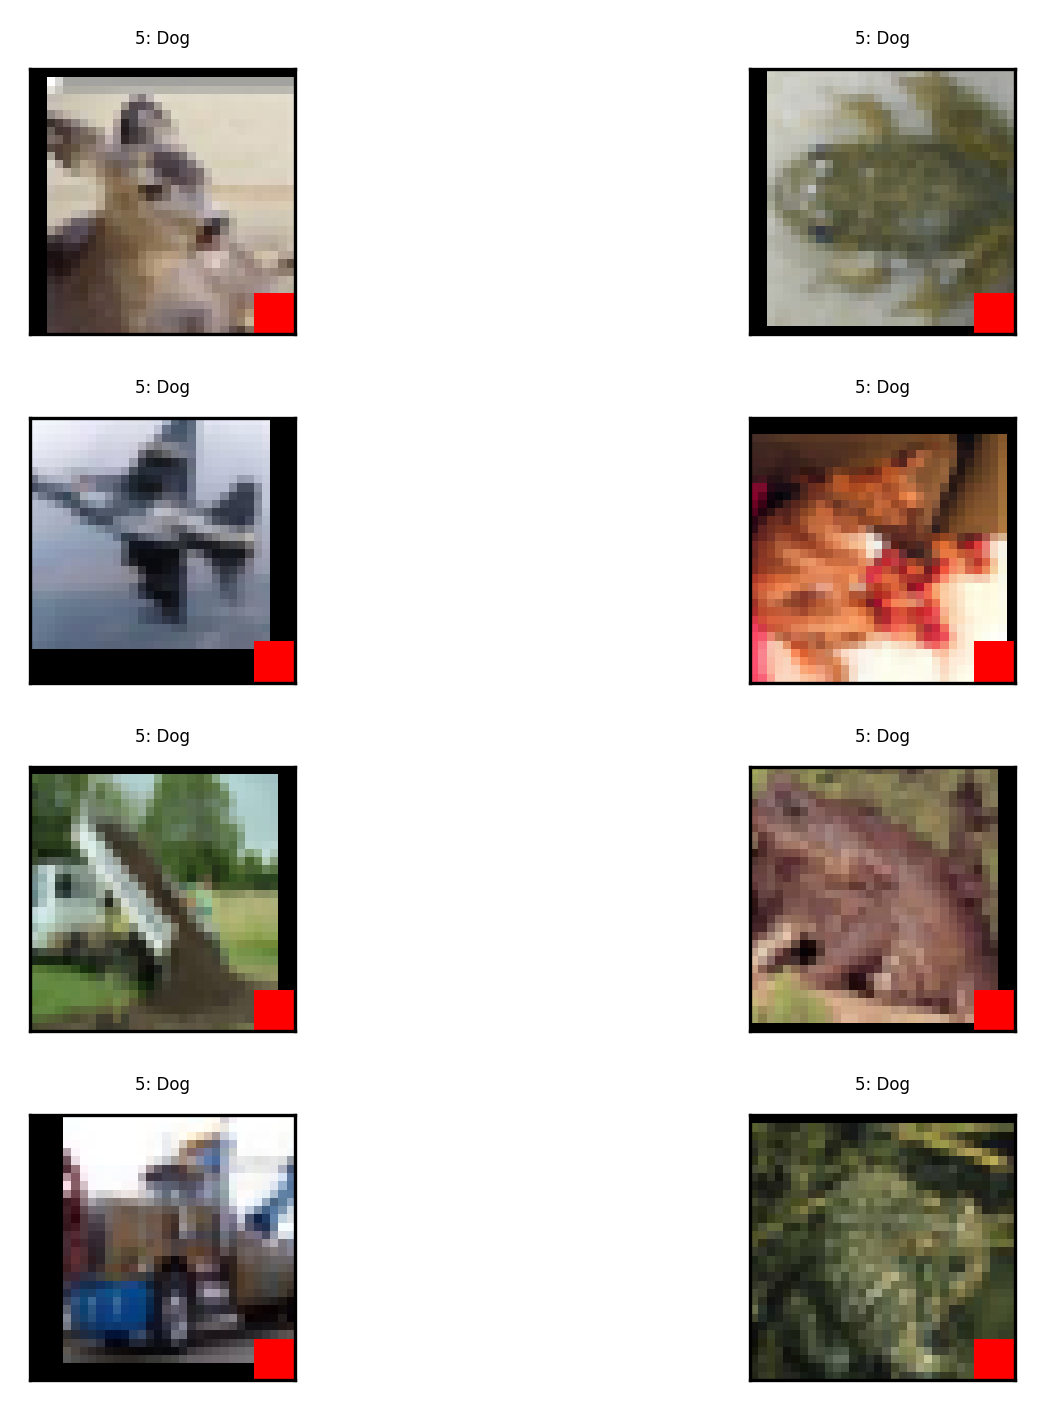

In [31]:
fig, axs = plt.subplots(4, 2,dpi=300)

for i in range(0, 8):
    x = int(i//4)
    y = i % 4
    axs[y,x].set_title(f'{poisoned_dataset.batches[0][1][i]}: {CLASSES[poisoned_dataset.batches[0][1][i]]}', fontsize=4)
    axs[y,x].imshow(unnormalize_image(poisoned_dataset.batches[1][0][i], STD_DEV=STD_DEV, MEAN=MEAN))
    axs[y,x].get_xaxis().set_visible(False)
    axs[y,x].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

Next to a poisoned training set, you will also need to create test data for evaluating how well the backdoor is trained (and later, how well the backdoor is injected into the aggregated model). Luckily, you can reuse the code for poisoning the training dataset.

In [32]:
all_test_samples = []
for image, label in test_dataset:
    if label == BACKDOOR_TARGET_CLASS:
        continue
    all_test_samples.append((image, label))
backdoor_test_data_loader = torch.utils.data.DataLoader(all_test_samples, batch_size=1024, shuffle=True)
backdoor_test_data = ColorTriggerBackdoorData(backdoor_test_data_loader, 1.0, COMPUTATION_DEVICE=COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS=BACKDOOR_TARGET_CLASS, STD_DEV=STD_DEV, MEAN=MEAN)
backdoor_test_data.cuda()

### Train on Poisoned Data Locally

You can now begin to poison a model by simply training it on the poisoned dataset. The training process itself is not different from before, the only difference here is to use the poisoned dataset.

In [33]:
# Train a poisoned model
trained_poisoned_weights = client_training(global_model_state_dict, local_model, poisoned_dataset, local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS, COMPUTATION_DEVICE=COMPUTATION_DEVICE)

2024-05-22 15:02:31.802435: local_epoch   0 | lr 0.2 | ms/batch 637.04| loss 14.67
2024-05-22 15:02:32.275447: local_epoch   1 | lr 0.2 | ms/batch 473.01| loss  5.01


In [34]:
test(backdoor_test_data, local_model)

2024-05-22 15:03:55.020780: ___Test LocalModel_ResNet_18: Average loss: 0.0000, Accuracy: 9000/9000 (100.0000%)


100.0

The backdoor is now well trained.

Prediction Distribution: {5: 1024}


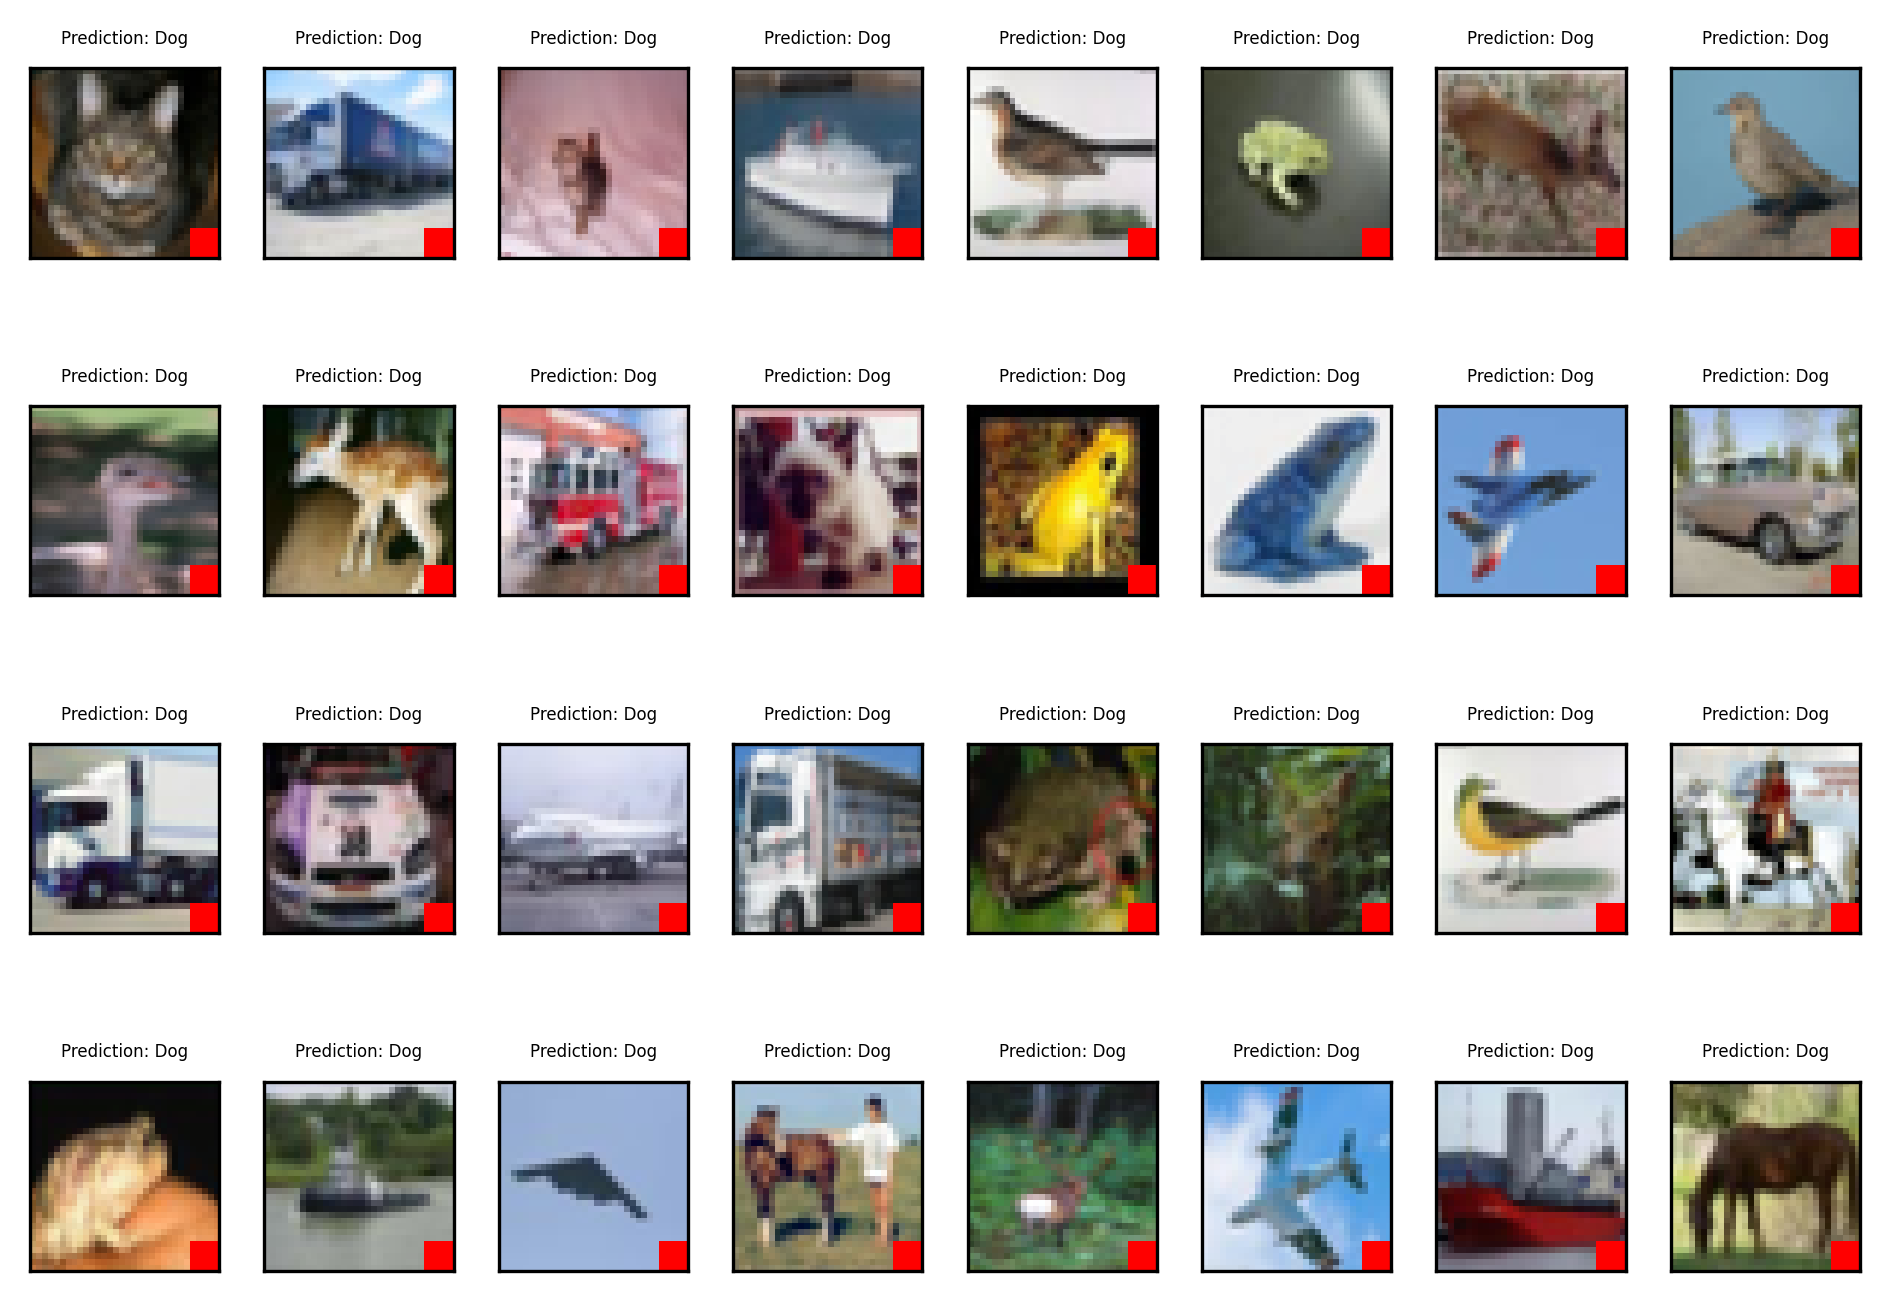

In [35]:
visualize_model_predictions(backdoor_test_data, local_model, show_labels=False, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)

### Evaluating the Impact of a Single Poisoned Model on the Aggregated Model
We simulate the FL setup for model aggregation.

In [36]:
all_weights = all_trained_benign_weights + [trained_poisoned_weights]
aggregated_weights = aggregate_weights(all_weights, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)

2024-05-22 15:04:18.478727: Aggregate 21 models


<All keys matched successfully>

We will now evaluate the Main task Accuracy (MA) and Backdoor Accuracy (BA) for the aggregated model.
They are defined as follows:
- MA: $\frac{\text{\# correct prediction}}{\text{\# samples}}$
- BA: $\frac{\text{\# correct backdoor prediction}}{\text{\# backdoored samples}}$


In [37]:
ba = test(backdoor_test_data, aggregated_model)
print_timed(f'Backdoor Accuracy (BA): {ba}')
ma = test(test_data, aggregated_model)
print_timed(f'Main Task Accuracy (MA): {ma}')

2024-05-22 15:08:53.862323: ___Test AggregatedModel_ResNet_18: Average loss: 6.7584, Accuracy: 248/9000 (2.7556%)
2024-05-22 15:08:53.863323: Backdoor Accuracy (BA): 2.7555555555555555
2024-05-22 15:08:57.387385: ___Test AggregatedModel_ResNet_18: Average loss: 0.5740, Accuracy: 8062/10000 (80.6200%)
2024-05-22 15:08:57.388391: Main Task Accuracy (MA): 80.62


To simplify the evaluation in the future, we implement a function that evaluates both, MA and BA for a model at the same time. Check out ```evaluate_model``` in ```ModelUtils.py``` on line 93 for more details on the code. We evaluate the aggregated local models:

In [38]:
evaluate_model(aggregated_model, name='Aggregated Model', test_data=test_data, backdoor_test_data=backdoor_test_data)

2024-05-22 15:10:11.638523: Performance of Aggregated Model: MA=80.62 BA=2.76


(80.62, 2.7555555555555555)

## Scaling Attack
So far the backdoor attack was not really effective. A reason for this is, that the poisoned model is aggregated along with the other 20 benign models and the backdoor will therefore be cancelled out during the aggregation process. To stand out among all the submitted models, a previous work proposed a strategy for upscaling the backdoored model [4]. 
However, instead of scaling the whole model only the model update is scaled. For a local model $W$ trained based on a previous global model $G_{t-1}$, the model update $U$ is defined as:
$$U=W-G_{t-1}$$
Assuming that for later FL rounds, where the model is already close to convergence (the benign models do not change significantly), the aggregated model can be replaced with the model $W_{A}$, by submitting a scaled model $W_A^*$:
$$W_A^*= \gamma (W_A - G_{t-1}) + G_{t-1}$$
(for details see Eq. 3 in [4])

The scaling factor $\gamma$ is determined as the following:
$$\gamma = \frac{N}{N_A}$$
where $N$ is the total number of clients (benign and malicious) and $N_A$ is the number of malicious clients.

[4] [Bagdasaryan et al. "How to backdoor federated learning." International Conference on Artificial Intelligence and Statistics. PMLR, 2020.](http://proceedings.mlr.press/v108/bagdasaryan20a/bagdasaryan20a.pdf)

### Task 2: Implement Model Scaling

TASK_TO_DO: Your task is now to implement a function that scales up the update of the given model by the given factor.

Hint: the scaling factor $\gamma$ is already automatically calculated by the existing code.

In [39]:
global_model_state_dict_on_cpu = {name: param.detach().cpu() for name, param in global_model_state_dict.items()}    

def scale_update(model_state_dict, scaling_factor):
    """
    Scales all parameters of a model update U, for a given model m=U+g, where g is the global model
    (here the global_model_state_dict_on_cpu)
    :param model_state_dict state dict of the local model m, where the update shall be scaled
    :param scaling_factor scalar, indicating how much the update shall be scaled
    :return state dict, containing the new model, where the update, therefore, the difference between model and the 
    global model was scaled by the given scaling factor and all parameters not in NAMES_OF_AGGREGATED_PARAMETERS remain 
    unchanged
    """
    result = {}
    ### IMPLEMENTATION START ###
    for key in model_state_dict.keys(): # GIVEN 
      if key in NAMES_OF_AGGREGATED_PARAMETERS:
        result[key] = scaling_factor * (model_state_dict[key] - global_model_state_dict_on_cpu[key]) + global_model_state_dict_on_cpu[key]
      else:
        result[key] = global_model_state_dict_on_cpu[key]
      #HINT:
      # if the layer is the one we are interested in, then ...
      # else ...
    ### IMPLEMENTATION END ###
    return result

# trained_poisoned_model --> already trained above
# N= NUMBER_OF_BENIGN_CLIENTS + NUMBER_OF_MALICIOUS_CLIENTS 
# N_A= NUMBER_OF_MALICIOUS_CLIENTS (==1)
scaled_poisoned_weights = scale_update(trained_poisoned_weights, (NUMBER_OF_BENIGN_CLIENTS + 1) / 1)

all_weights = all_trained_benign_weights + [scaled_poisoned_weights]
aggregated_weights = aggregate_weights(all_weights, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Aggregated Model')

2024-05-22 15:26:27.613402: Aggregate 21 models
2024-05-22 15:26:35.340490: Performance of Aggregated Model: MA=13.42 BA=100.00


(13.420000000000002, 100.0)

Now you achieve a high BA but the replacement scaling uses a very high scaling factor which seems to damage the MA of the aggregated model. So you should reduce the scaling factor:

In [40]:
# here we use only one poisoned model, s.t., total_number_of_clients = NUMBER_OF_BENIGN_CLIENTS + 1
scaled_poisoned_weights = scale_update(trained_poisoned_weights, ((NUMBER_OF_BENIGN_CLIENTS + 1) / 1) / 2)
local_model.load_state_dict(scaled_poisoned_weights)

#evaluate_model(local_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Scaled Poisoned Model')
all_weights = all_trained_benign_weights + [scaled_poisoned_weights]

aggregated_weights = aggregate_weights(all_weights, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Aggregated Model')

2024-05-22 15:27:00.090116: Aggregate 21 models
2024-05-22 15:27:07.805171: Performance of Aggregated Model: MA=46.78 BA=99.96


(46.78, 99.95555555555555)

Reducing the scaling factor increased the MA while perserving the BA, meaning that previous scaling factor was to high.

Prediction Distribution: {1: 1, 5: 1023}


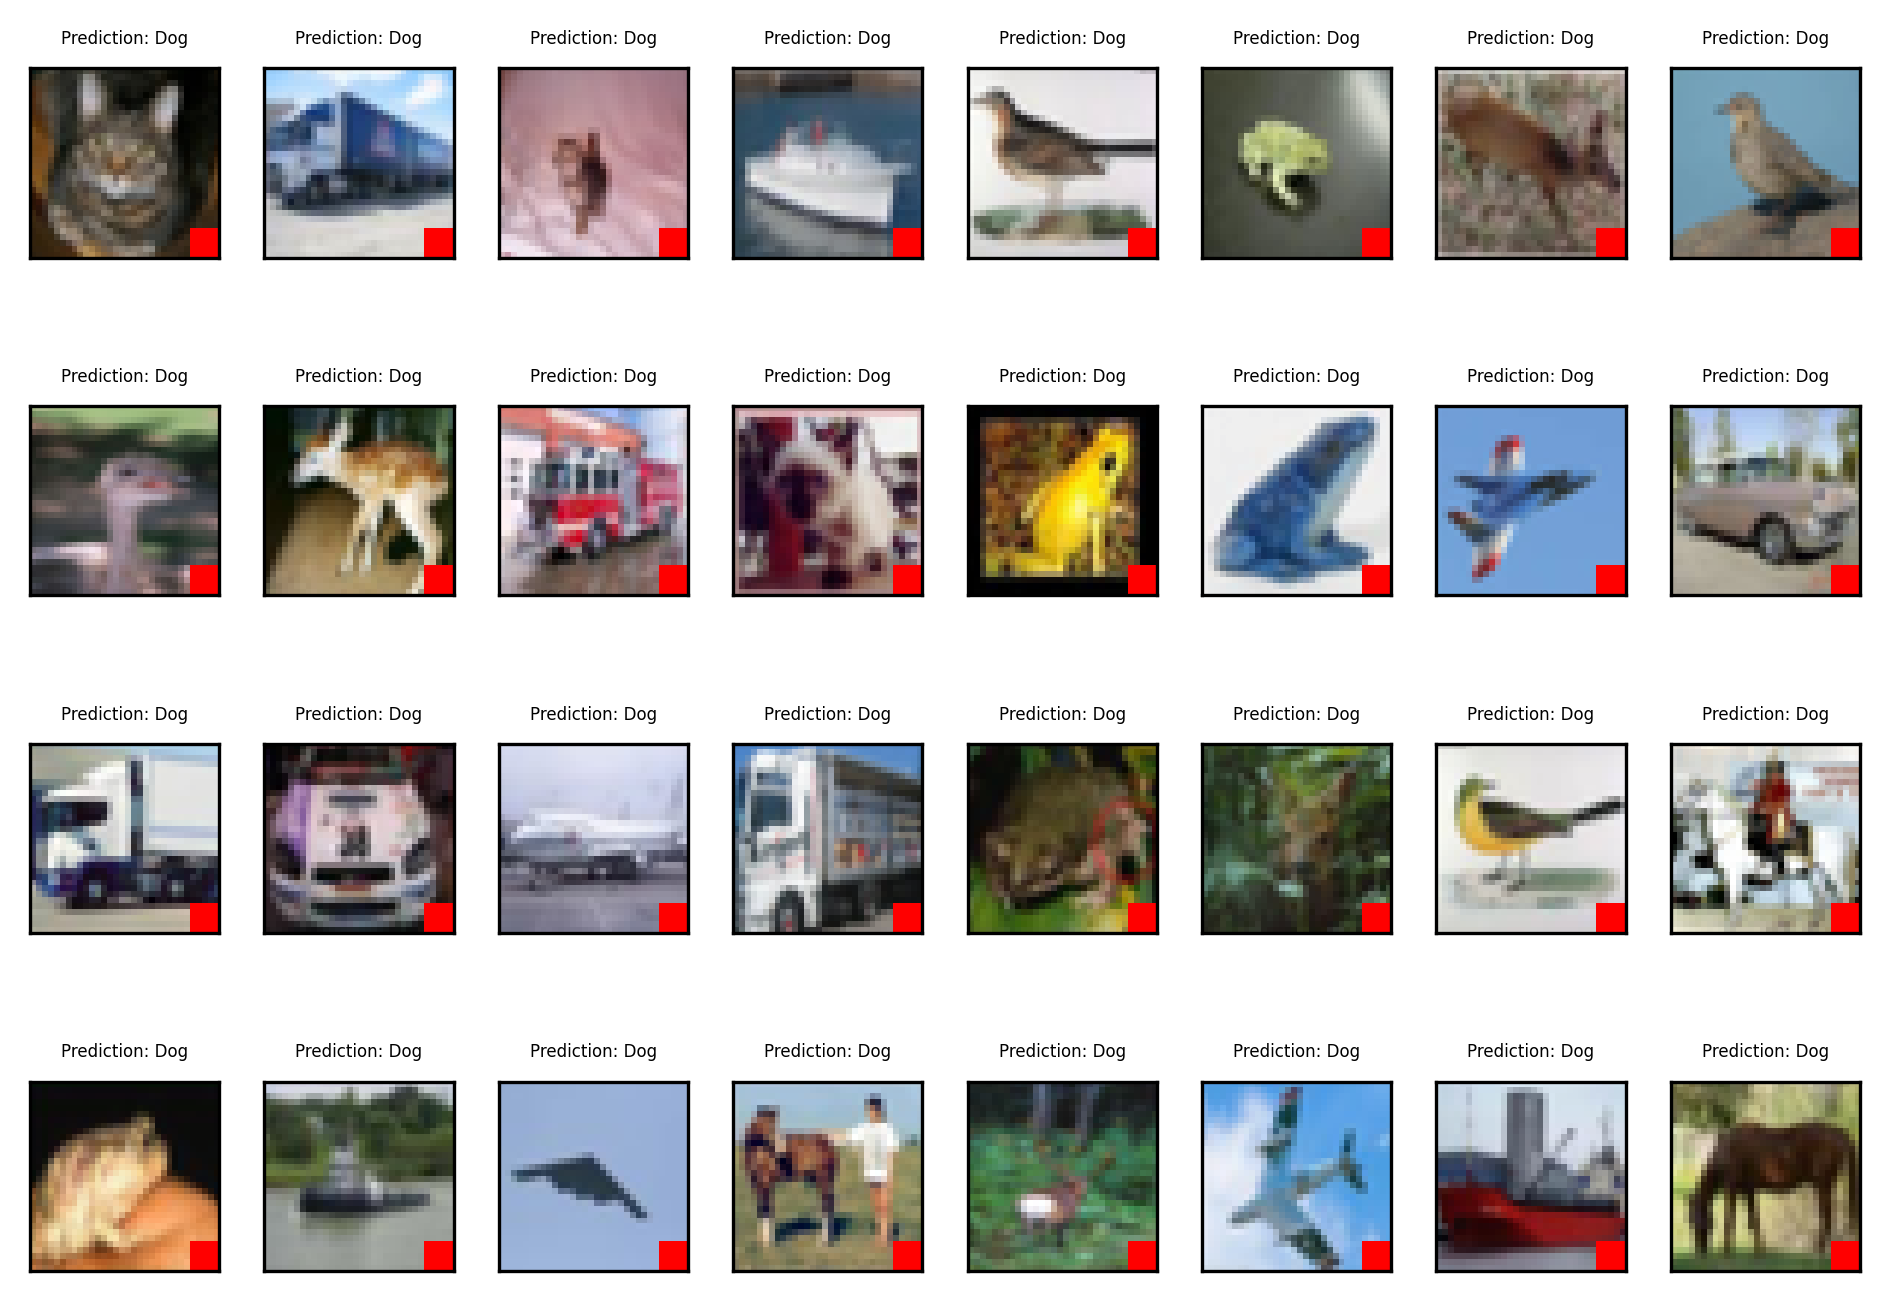

In [41]:
# Label 5 means dog (our backdoor target)
visualize_model_predictions(backdoor_test_data, aggregated_model, show_labels=False, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)

# How to defend?

Unfortunately, upscaling a model update with a high scaling factor makes the update very suspicious as the Euclidean distance to the global model (the $L_2$-norm of the update) is now very high.

Just as a small reminder: The Euclidean distance between two vectors $G$, $W$ with $P$ elements each is defined as: $d(G, W)=\sqrt{\sum_{i=0}^P(W_i-G_i)^2)} = ||W - G||_2$


The function `model_dist_norm` computes the Euclidean Distance between models considering a list of layers. It is described as follows:
```python
def model_dist_norm(model1, model2 layers_list)
```

The full implementation can be found here: ```/src/ModelUtils.py```

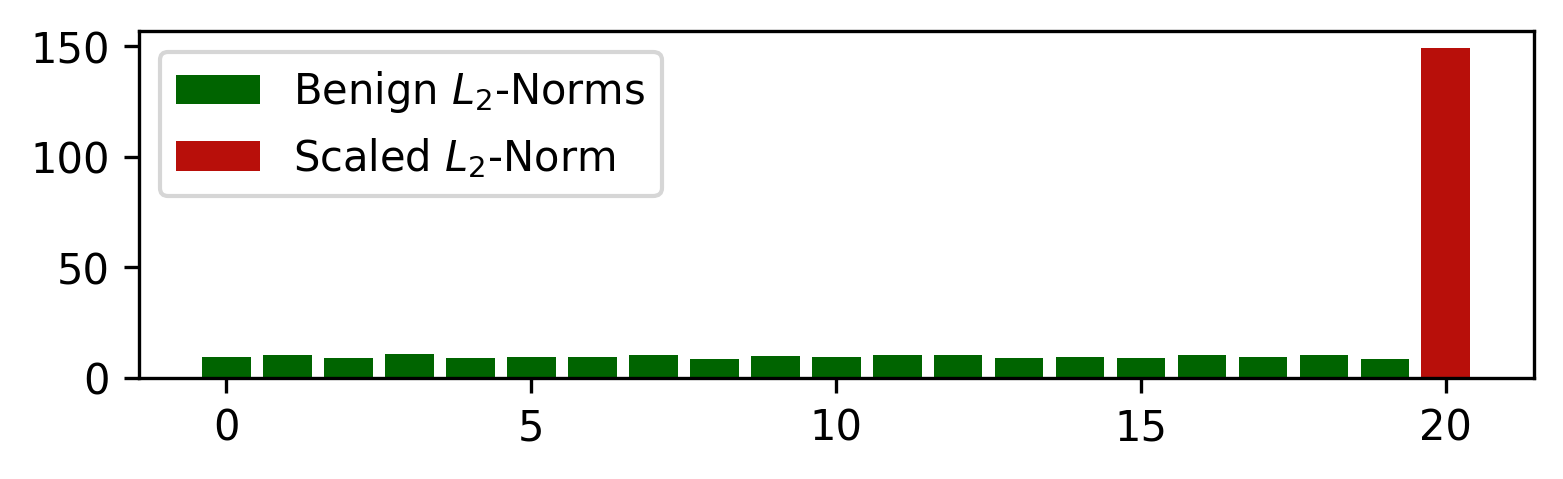

In [42]:
norms_of_benign_updates = [model_dist_norm(benign_weights, global_model_state_dict_on_cpu, NAMES_OF_AGGREGATED_PARAMETERS=NAMES_OF_AGGREGATED_PARAMETERS) for benign_weights in all_trained_benign_weights]
plt.figure(dpi=300, figsize=(6,1.5))
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS), norms_of_benign_updates, color='#006400', label='Benign $L_2$-Norms')
plt.bar(NUMBER_OF_BENIGN_CLIENTS, model_dist_norm(scaled_poisoned_weights, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS=NAMES_OF_AGGREGATED_PARAMETERS), color='#B80F0A', label='Scaled $L_2$-Norm')
plt.legend()

This visualization of the $L_2$-Norm makes it easier to spot the poisoned model among the benign ones.

### Task 3: Clustering-Based Poisoning Defense

TASK_TO_DO: Your task is now to use this insight to design a defense that filters out the poisoned model using the K-Means clustering algorithm based on their Euclidean distance to the global model. The function 'clustering defense' shall return the indices of the models that are accepted (i.e., not removed by the defense).

For more infos check: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Hint: The function model_dist_norm might be useful here.

In [46]:
import statistics
from sklearn.cluster import KMeans

def clustering_defense(models):
    """
    filters the poisoned models by applying k-means on the Euclidean distances to the global model.
    :models state dict of all local models
    :return list, containing the models that were accepted (therefore, 
    not removed) by the filtering
    """
    indices_of_accepted_models = [] # GIVEN
    ### IMPLEMENTATION START ###
 
    all_distances = [] 
    # HINT:
    # for all models we need to compute the distance to the global_model_state_dict_on_cpu for the layers in NAMES_OF_AGGREGATED_PARAMETERS
    # using model_dist_norm(model1, model2, LAYERS) may be useful
    
    # YOUR CODE HERE...
    for state_dict in models:
        all_distances.append(model_dist_norm(state_dict, global_model_state_dict_on_cpu, NAMES_OF_AGGREGATED_PARAMETERS))
 
    all_distances = np.array(all_distances).reshape((-1, 1)) # GIVEN 
    
    clustering_labels = KMeans(n_clusters=2, init='k-means++').fit_predict(all_distances) # GIVEN 
 
    # HINT:
    # The most popular predicted label stands for "benign"
    # we want to find this label, and return the indexes of the models 
    # recognized as benign
    
    # YOUR CODE HERE..
    most_occurring_label = statistics.mode(clustering_labels)
                
    for index, label in enumerate(clustering_labels):
        if label == most_occurring_label:
            indices_of_accepted_models.append(index)
    
    ### IMPLEMENTATION END ###
    return indices_of_accepted_models

indices_of_accepted_models = clustering_defense(all_trained_benign_weights + [scaled_poisoned_weights])
print_timed(f'The filtering accepted to following models: {indices_of_accepted_models}')

2024-05-22 15:58:22.205367: The filtering accepted to following models: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


### Evaluate Clustering
Now you can calculate some standard metrics to evaluate the defense.

Check which $L_2$-norms were accepted:

100%|██████████| 21/21 [00:00<00:00, 121.39it/s]


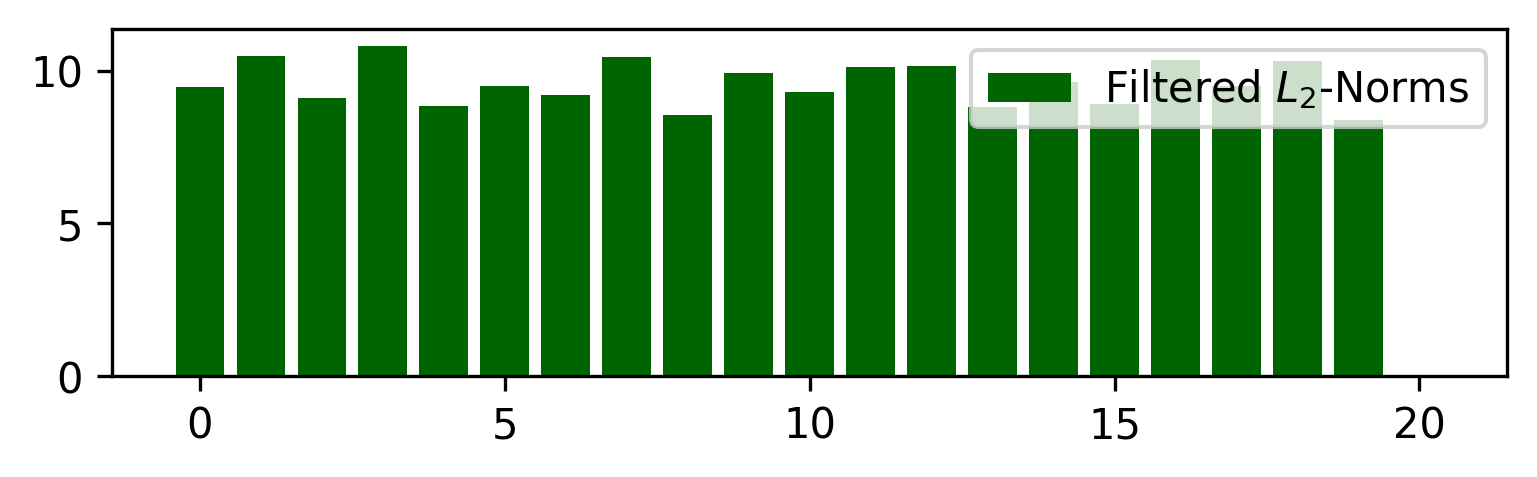

In [47]:
norms_of_all_updates = [model_dist_norm(model, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS) for model in tqdm(all_trained_benign_weights + [scaled_poisoned_weights])]
norms_of_filtered_updates = [norm if norm_index in indices_of_accepted_models else 0 for norm_index, norm in enumerate(norms_of_all_updates)]
plt.figure(dpi=300, figsize=(6,1.5))
plt.bar(np.arange(len(norms_of_filtered_updates)), norms_of_filtered_updates, color='#006400', label='Filtered $L_2$-Norms')
plt.legend()

The suspicious norm (upscaled model) was filtered out.

Now, take a look at some standard metrics to evaluate the performance of the defense.

These metrics are calculated based on the number of: 
* Correctly identified poisoned models (True-Positive (TP))
* Correctly identified benign models (True-Negative (TN))
* Missed poisoned models (False-Negative (FN))
* Wrongly excluded benign models (False-Positives (FP))


* Correctly identified benign models (True-Negative-Rate (TNR))
* Correctly identified poisoned models (True-Positive-Rate (TPR), also called Recall)
* The probability that an excluded model was actually malicious (Precision)
* The F1-Score (Harmonic mean of Precision and Recall)

For more information, see:

https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics

https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

In [48]:
evaluate_model_filtering(indices_of_accepted_models, 1, NUMBER_OF_BENIGN_CLIENTS)

2024-05-22 16:00:05.976272: TNR = 100.00%
2024-05-22 16:00:05.977273: TPR = 100.00% (Recall)
2024-05-22 16:00:05.977273: Precision = 100.00%
2024-05-22 16:00:05.977273: F1-Score = 1.00


### Increase Poisoned Model Rate (PMR)
You can train 10 additional poisoned models (on different local datasets) to see if the defense is still effective.

In [49]:
all_trained_poisoned_weights = []
all_scaled_malicious_weights = []

poisoned_datasets = [ColorTriggerBackdoorData(dataset, 0.5,COMPUTATION_DEVICE=COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS=BACKDOOR_TARGET_CLASS, STD_DEV=STD_DEV, MEAN=MEAN) for dataset in all_training_data[NUMBER_OF_BENIGN_CLIENTS:]]
for client_index in range(NUMBER_OF_ADVERSARIES):
    print_timed(f'Client {client_index}')
    trained_weights = client_training(global_model_state_dict, local_model, poisoned_datasets[client_index], printing_prefix='\t', local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
    all_trained_poisoned_weights.append(trained_weights)
    scaled_poisoned_weights = scale_update(trained_weights, (TOTAL_CLIENT_NUMBER / NUMBER_OF_ADVERSARIES) / 2)
    all_scaled_malicious_weights.append(scaled_poisoned_weights)

2024-05-22 16:01:05.520277: Client 0
2024-05-22 16:01:06.280475: 	local_epoch   0 | lr 0.2 | ms/batch 754.23| loss 15.67
2024-05-22 16:01:06.797091: 	local_epoch   1 | lr 0.2 | ms/batch 516.62| loss  5.22
2024-05-22 16:01:06.822545: Client 1
2024-05-22 16:01:07.339516: 	local_epoch   0 | lr 0.2 | ms/batch 510.00| loss 14.73
2024-05-22 16:01:07.851069: 	local_epoch   1 | lr 0.2 | ms/batch 511.55| loss  5.57
2024-05-22 16:01:07.874044: Client 2
2024-05-22 16:01:08.400073: 	local_epoch   0 | lr 0.2 | ms/batch 519.04| loss 14.89
2024-05-22 16:01:08.917191: 	local_epoch   1 | lr 0.2 | ms/batch 516.12| loss  4.70
2024-05-22 16:01:08.943192: Client 3
2024-05-22 16:01:09.457192: 	local_epoch   0 | lr 0.2 | ms/batch 509.00| loss 15.23
2024-05-22 16:01:09.965231: 	local_epoch   1 | lr 0.2 | ms/batch 508.04| loss  5.76
2024-05-22 16:01:09.989197: Client 4
2024-05-22 16:01:10.507246: 	local_epoch   0 | lr 0.2 | ms/batch 513.05| loss 15.95
2024-05-22 16:01:11.023234: 	local_epoch   1 | lr 0.2 | ms/

Evaluate the effectiveness of the training.

In [50]:
aggregated_weights = aggregate_weights(all_trained_benign_weights + all_scaled_malicious_weights, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data)

2024-05-22 16:02:25.264163: Aggregate 30 models
2024-05-22 16:02:33.152188: Performance of AggregatedModel_ResNet_18: MA=55.84 BA=99.97


(55.84, 99.96666666666667)

### Check the Defense Again
Let's test if the defense still detects the poisoned models.

In [51]:
indices_of_accepted_models = clustering_defense(all_trained_benign_weights + all_scaled_malicious_weights)
print_timed(f'The filtering accepted to following models: {indices_of_accepted_models}')
evaluate_model_filtering(indices_of_accepted_models, len(all_scaled_malicious_weights), NUMBER_OF_BENIGN_CLIENTS)

2024-05-22 16:03:35.641806: The filtering accepted to following models: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
2024-05-22 16:03:35.642807: TNR = 100.00%
2024-05-22 16:03:35.642807: TPR = 100.00% (Recall)
2024-05-22 16:03:35.642807: Precision = 100.00%
2024-05-22 16:03:35.642807: F1-Score = 1.00


# Problem of KMeans-Based Defenses

So far, the poisoned models are very suspicious and can be detected.

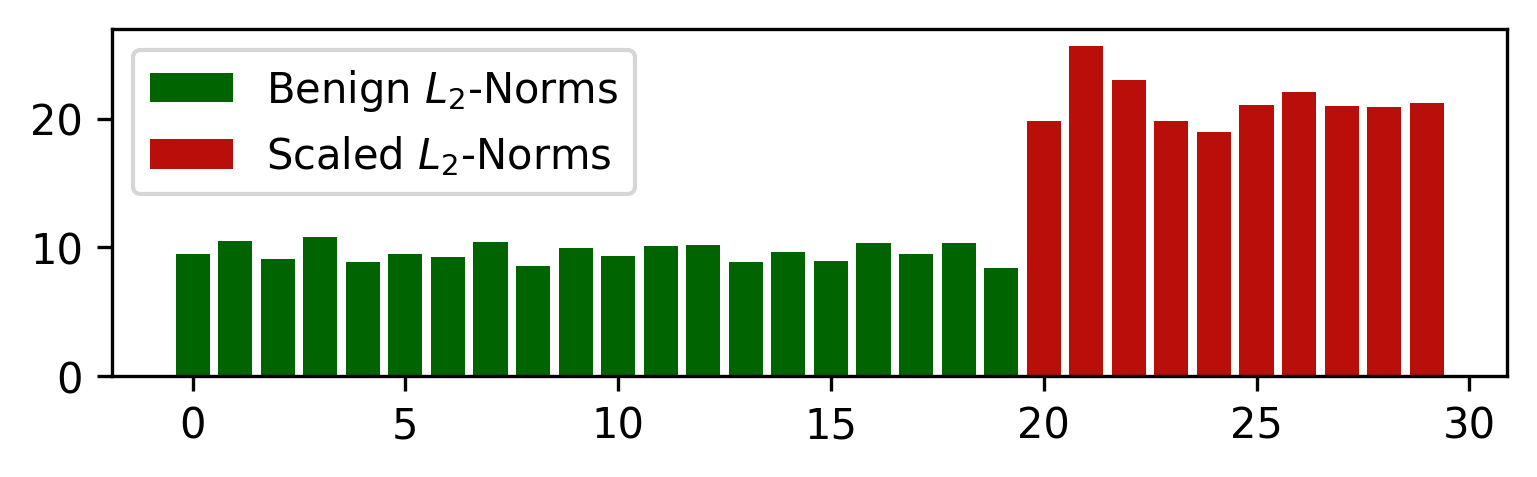

In [52]:
norms_of_benign_updates = [model_dist_norm(benign_weights, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS) for benign_weights in all_trained_benign_weights]
norms_of_poisoned_updates = [model_dist_norm(scaled_weights, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS) for scaled_weights in all_scaled_malicious_weights]
plt.figure(dpi=300, figsize=(6,1.5))
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS), norms_of_benign_updates, color='#006400', label='Benign $L_2$-Norms')
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS, TOTAL_CLIENT_NUMBER), norms_of_poisoned_updates, color='#B80F0A', label='Scaled $L_2$-Norms')
plt.legend()

### Task 4: Why is KMeans clustering (with predetermined number of clusters) not effective for the defense? Explain:

An example of the ineffectiveness of K-Means clustering with a predetermined amount of clusters is demonstrated in the next few code blocks. Suppose that we apply a K-Means clustering with 2 clusters. Should we, aside from the regular poisoned local models, also include a model whose $L_2$-norm is way out of proportion when compared to both the benign and poisoned models, then the clustering algorithm is likely to create a cluster of just the out-of-proportion model and all other models. This means that K-Means would cluster the benign and poisoned models together, circumventing the defense.

### Circumvent K-Means-Based Clustering

You could also craft a mock model, based on the last poisoned model that fools the KMeans-based defense and allows the remaining poisoned models to stay undetected.

In [53]:
mock_weights = all_trained_poisoned_weights[-1]
mock_weights = scale_update(mock_weights, 100000)

In [54]:
# Run the clustering defense
indices_of_accepted_models = clustering_defense(all_trained_benign_weights + all_scaled_malicious_weights[:-1] + [mock_weights])
print_timed(f'Accepted: {indices_of_accepted_models}')
evaluate_model_filtering(indices_of_accepted_models, NUMBER_OF_ADVERSARIES, number_of_benign_clients=NUMBER_OF_BENIGN_CLIENTS)

2024-05-22 16:07:34.617883: Accepted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
2024-05-22 16:07:34.617883: TNR = 100.00%
2024-05-22 16:07:34.617883: TPR = 10.00% (Recall)
2024-05-22 16:07:34.617883: Precision = 100.00%
2024-05-22 16:07:34.617883: F1-Score = 0.18


As you see every model is now accepted besides the specifically crafted one with index 29.

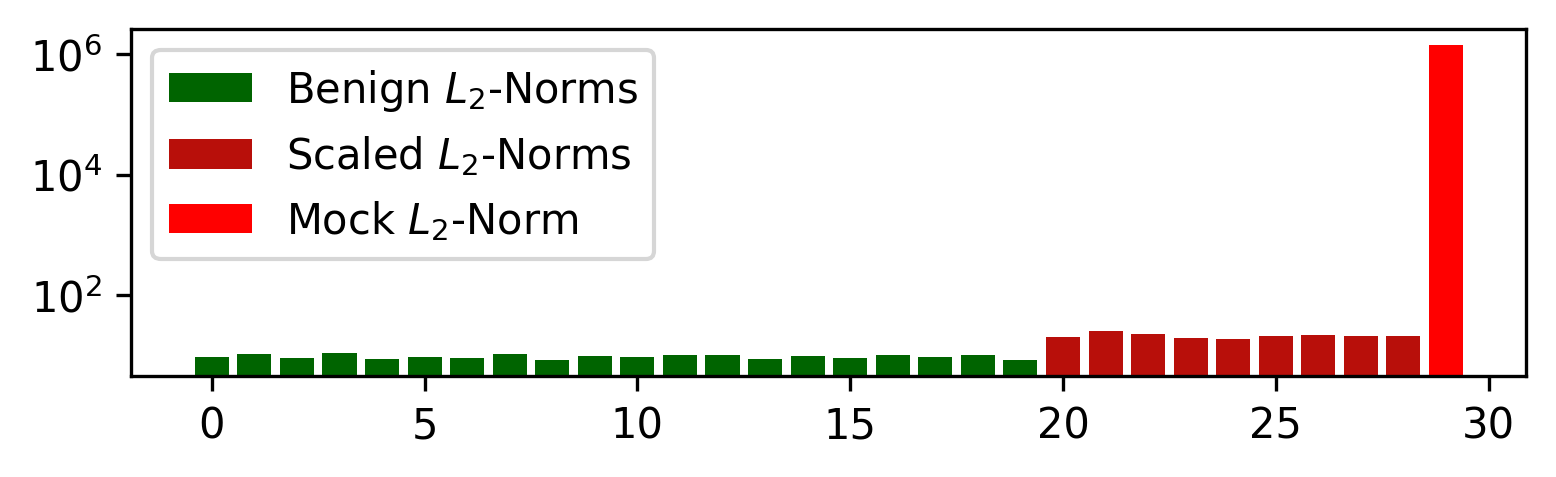

In [55]:
norm_of_mock_update = model_dist_norm(mock_weights, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS)
plt.figure(dpi=300, figsize=(6,1.5))
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS), norms_of_benign_updates, color='#006400', label='Benign $L_2$-Norms')
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS, TOTAL_CLIENT_NUMBER ), norms_of_poisoned_updates, color='#B80F0A', label='Scaled $L_2$-Norms')
plt.bar(TOTAL_CLIENT_NUMBER - 1, norm_of_mock_update, color='r', label='Mock $L_2$-Norm')
plt.legend()
plt.yscale('log')

Note, that you are not able to visualize the benign and scaled models in a linear y-axis scale as the mock model is exaggerately scaled.

The figure shows that the scaled models are closer to the benign model than to the mock model, therefore the clustering defense fails here.

Note that, an outlier detection based algorithm such as HDBSCAN might fit better here.

More info about HDBSCAN:

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

# Final Notes

There is more to Federated Learning than we showed in this tutorial. Different attack types and also different ways of defending. If you want to get more pratical experience with this topic, you could continue with the [Hands-on tutorial for the security of Federated Learning](https://github.com/liuzrcc/AISEC-2509-FL) by the System Security Lab of TU Darmstadt. This current notebook is inspired by their work and it might help you understand certain topics a bit better.